# Neo4J vs MySQL

## Project Description

Graph databases are specialized data systems to query interconnected data. To this extent, they leverage optimised data structures and indexes that speed up the processing of highly complex queries.

This project requires you to implement a family of path query using MySQL and evaluate the performance difference.

The queries you have to implement investigate the FRIEND relationship with increasing number of hops

For example, given the following graph, and assuming the transitivity of FRIEND and n.id <> m.id

Alice -[FRIEND]-> Bob
Bob -[FRIEND]-> Carl
Carl -[FRIEND]-> Dave

1. (n) -[FRIEND]-> (m) will return n=Alice,m=Bob;n=Bob,m=Carl;n=Carl,m=Dave

2. (n) -[FRIEND*1..2]-> (m) will return what 1. returned, and n=Alice,m=Carl, n=Bob,m=Dave

and so on...


You can:

- use code or SQL to achieve the query result
- you can use/create any helper structure, table
- if you use any index in mysql, justify their presence by measuring their impact
- You can use recursive SQL queries

## Environment Setup

We will be using MySQL 8.0 and Neo4J as relational and graph databases respectively.

For queries on MySQL you can use recursive queries as discussed in the lecture, or you can come with any auxiliary tables, SQL procedures/functions that help achieve the goal.

#### Special handling for Neo4J container

The `docker-compose up -d` command might cause on some hosts that the Neo4J container has problems with the default Neo4J databse being unavailable.

To work around this issue, you need to:

1. stop the current neo4j container by the command `docker stop <neo4j-container name>
2. You need to spawn a new container by the docker run command as `docker run -d --rm --name neo -p 7474:7474 -p 7687:7687 neo4j:4.4.6-community`. This command will start a new container with the same version as the one in the yml file.
3. Link the container to the same network of the MySQL and the Notebook containers, `docker network connect graph_default neo`
4. When the neo4J container is started, use the web interface setup first to create the neo4j password. You can access the web interface via http://localhost:7474/browser/. You can make the initial login with neo4j/neo4j and then you can create the new password. This password will be supplied when connecting to neo4J via the py2neo connector later.

## Objectives

In the following, we generate a random graph of FRIEND relationship. You should repeat for the different sizes indicated below

For each generated graph
1. Load the data to Neo4J, you can choose to create a separate database or drop and create the same database
2. Apply the queries indicated below and note the execution time taken for each query for each database
3. Load the same generated graph to MySQL database, example code below.
4. Come up with the equivalent SQL queries for the different cypher queries
5. Run these queries against MySQL and note the runtime of it.
6. Plot the runtime of each query for the Neo4J against MySQL

## Grading
1. Run the Neo4J queries [10 points]
2. One-Hop SQL query [10 points]
1. 2+-hops queries [30 points]. You can build a parameterized template that takes N as a parameter.
1. Creating indexes, you need to explain and include command, [10 points]. Indexes are possible on both graph and relational databases
1. Plotting and comparing runtimes between relational and graph databases [10 points]


# Generate the Data


<img src="schema.png" alt="5" border="0">

Try different sizes 100,500,1000,10000

In [1]:
friendsNum = 100#500/1000

In [2]:
import random
import sys
import time

num_people = int(friendsNum)
num_friends = int(friendsNum/2)

friendids = range(1,num_people+1)
friends={}
for i in friendids:
    while 1:
        sample = random.sample(friendids,num_friends)
        if i not in sample:
            break
    friends[i]=sample
    if i % 10000 == 0:
        print(i)

In [3]:
print(friends)

{1: [48, 37, 44, 36, 82, 19, 90, 32, 69, 49, 60, 80, 27, 51, 55, 26, 3, 92, 81, 53, 66, 25, 65, 87, 20, 13, 57, 28, 74, 38, 47, 85, 70, 16, 89, 56, 54, 50, 59, 62, 99, 64, 45, 24, 33, 61, 58, 40, 14, 18], 2: [16, 39, 79, 43, 90, 94, 42, 74, 98, 65, 26, 96, 49, 72, 35, 59, 68, 82, 18, 28, 25, 5, 14, 10, 52, 48, 57, 22, 78, 84, 1, 61, 73, 88, 81, 30, 60, 92, 53, 58, 7, 93, 31, 77, 15, 12, 54, 89, 37, 91], 3: [9, 22, 75, 28, 31, 87, 94, 57, 95, 52, 42, 40, 98, 26, 91, 49, 43, 83, 35, 51, 2, 84, 65, 89, 29, 78, 80, 63, 97, 86, 12, 96, 20, 32, 27, 100, 64, 36, 24, 5, 21, 46, 48, 39, 25, 72, 92, 7, 60, 4], 4: [65, 52, 23, 12, 66, 21, 25, 89, 61, 41, 24, 85, 36, 7, 54, 86, 73, 33, 78, 10, 8, 59, 90, 45, 43, 37, 38, 34, 95, 75, 80, 91, 19, 60, 81, 57, 3, 53, 1, 44, 82, 83, 17, 22, 84, 39, 31, 97, 72, 58], 5: [24, 54, 84, 31, 69, 76, 65, 29, 17, 70, 80, 96, 47, 89, 32, 72, 52, 1, 4, 59, 13, 51, 55, 98, 83, 15, 67, 63, 95, 43, 30, 22, 35, 16, 8, 38, 39, 3, 14, 23, 49, 85, 41, 48, 50, 7, 57, 68, 

In [4]:
fplot = {}
for f,fs in friends.items():
    fplot[f]=len(fs)

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

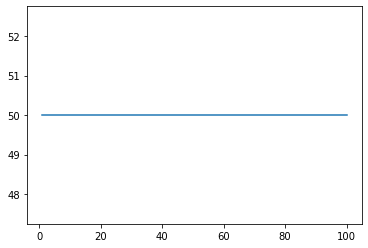

In [6]:
lists = sorted(fplot.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

Example graph with 10 People.

<img src="graph.png" alt="5" border="0">

## Import Data to Neo4J


### py2neo

py2neo is one of Neo4j's Python drivers. It offers a fully-featured interface for interacting with your data in Neo4j. Install py2neo with pip install py2neo.


In [7]:
! pip install py2neo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.0/177.0 KB 2.1 MB/s eta 0:00:00a 0:00:01


In [8]:
pip show py2neo

Name: py2neo
Version: 2021.2.3
Summary: Python client library and toolkit for Neo4j
Home-page: https://py2neo.org/
Author: Nigel Small
Author-email: technige@py2neo.org
License: Apache License, Version 2.0
Location: /opt/conda/lib/python3.9/site-packages
Requires: certifi, interchange, monotonic, packaging, pansi, pygments, six, urllib3
Required-by: 
Note: you may need to restart the kernel to use updated packages.



### Connect

Connect to Neo4j with the Graph class.


In [18]:
from py2neo import Node,Graph, Relationship, NodeMatcher
try:
    graph = Graph("bolt://neo:7687", auth=('neo4j','admin'))
except:
    print("Error Connection to Neo4j DB!!")

## create nodes and relationship

In [19]:
nodes = NodeMatcher(graph)
for p,fs in friends.items():
    ##pn = Node("Person", id=p, name="Person"+str(p))
    cypher_ = "CREATE (:Person {id:"+str(p)+", name:'Person"+str(p)+"'})"
    graph.run(cypher_)

In [22]:
## we can check how many nodes have we insterted.
len(graph.nodes.match("Person"))

100

In [23]:
for p,fs in friends.items():
    pn = nodes.match("Person", id=p, name="Person"+str(p)).first()
    for f in fs:
        fn = nodes.match("Person", id=f, name="Person"+str(f)).first()
        r  = Relationship(pn, "FRIEND", fn)
        graph.create(r)

## RUN THIS QUERY 3-5 TIMES TO WARM UP THE CACHE

In [28]:
query = """ MATCH (n:Person)-[r]-> (m) RETURN n.id as n,m.id as m"""
ns = []
for node in graph.run(query):
     ns.append(node)

In [30]:
ns

[Record({'n': 1, 'm': 48}),
 Record({'n': 1, 'm': 37}),
 Record({'n': 1, 'm': 44}),
 Record({'n': 1, 'm': 36}),
 Record({'n': 1, 'm': 82}),
 Record({'n': 1, 'm': 19}),
 Record({'n': 1, 'm': 90}),
 Record({'n': 1, 'm': 32}),
 Record({'n': 1, 'm': 69}),
 Record({'n': 1, 'm': 49}),
 Record({'n': 1, 'm': 60}),
 Record({'n': 1, 'm': 80}),
 Record({'n': 1, 'm': 27}),
 Record({'n': 1, 'm': 51}),
 Record({'n': 1, 'm': 55}),
 Record({'n': 1, 'm': 26}),
 Record({'n': 1, 'm': 3}),
 Record({'n': 1, 'm': 92}),
 Record({'n': 1, 'm': 81}),
 Record({'n': 1, 'm': 53}),
 Record({'n': 1, 'm': 66}),
 Record({'n': 1, 'm': 25}),
 Record({'n': 1, 'm': 65}),
 Record({'n': 1, 'm': 87}),
 Record({'n': 1, 'm': 20}),
 Record({'n': 1, 'm': 13}),
 Record({'n': 1, 'm': 57}),
 Record({'n': 1, 'm': 28}),
 Record({'n': 1, 'm': 74}),
 Record({'n': 1, 'm': 38}),
 Record({'n': 1, 'm': 47}),
 Record({'n': 1, 'm': 85}),
 Record({'n': 1, 'm': 70}),
 Record({'n': 1, 'm': 16}),
 Record({'n': 1, 'm': 89}),
 Record({'n': 1, 'm':

## 1 HOP

In [31]:
start = time.time()
query = """ MATCH (n:Person)-[r*1..2]-> (m) WHERE n.id <> m.id RETURN n.id as n,m.id as m"""
ns = []
for node in graph.run(query):
     ns.append(node)
print(time.time()-start)

3.1425342559814453


In [32]:
ns

[Record({'n': 1, 'm': 18}),
 Record({'n': 1, 'm': 93}),
 Record({'n': 1, 'm': 85}),
 Record({'n': 1, 'm': 66}),
 Record({'n': 1, 'm': 51}),
 Record({'n': 1, 'm': 68}),
 Record({'n': 1, 'm': 42}),
 Record({'n': 1, 'm': 96}),
 Record({'n': 1, 'm': 87}),
 Record({'n': 1, 'm': 6}),
 Record({'n': 1, 'm': 5}),
 Record({'n': 1, 'm': 76}),
 Record({'n': 1, 'm': 44}),
 Record({'n': 1, 'm': 20}),
 Record({'n': 1, 'm': 8}),
 Record({'n': 1, 'm': 29}),
 Record({'n': 1, 'm': 86}),
 Record({'n': 1, 'm': 26}),
 Record({'n': 1, 'm': 35}),
 Record({'n': 1, 'm': 83}),
 Record({'n': 1, 'm': 90}),
 Record({'n': 1, 'm': 63}),
 Record({'n': 1, 'm': 98}),
 Record({'n': 1, 'm': 45}),
 Record({'n': 1, 'm': 7}),
 Record({'n': 1, 'm': 47}),
 Record({'n': 1, 'm': 30}),
 Record({'n': 1, 'm': 11}),
 Record({'n': 1, 'm': 9}),
 Record({'n': 1, 'm': 14}),
 Record({'n': 1, 'm': 89}),
 Record({'n': 1, 'm': 58}),
 Record({'n': 1, 'm': 54}),
 Record({'n': 1, 'm': 34}),
 Record({'n': 1, 'm': 16}),
 Record({'n': 1, 'm': 10}

## 2 HOPS

In [ ]:
start = time.time()
query = """ MATCH (n:Person)-[r*1..3]-> (m) WHERE n.id <> RETURN n.id as n,m.id as m"""
ns = []
for node in graph.run(query):
     ns.append(node)
print(time.time()-start)

In [ ]:
ns

## 5 HOPS

In [ ]:
start = time.time()
query = """ MATCH (n:Person)-[r*1..5]-> (m) WHERE n.id <> m.id RETURN n.id as n,m.id as m"""
ns = []
for node in graph.run(query):
     ns.append(node)
print(time.time()-start)

In [ ]:
ns

## N HOPS

In [ ]:
start = time.time()
query = """ MATCH (n:Person)-[r*]-> (m) WHERE n.id <> m.id RETURN n.id as n,m.id as m"""
ns = []
for node in graph.run(query):
     ns.append(node)
print(time.time()-start)

In [ ]:
ns

## Import Data to MySQL

## mysql-connector

In [33]:
! pip install mysql-connector-python 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.2/25.2 MB 14.1 MB/s eta 0:00:0000:0100:01


### Connect

Connect to MySQL and configure the database




In [35]:
import mysql.connector

mydb = mysql.connector.connect(
  host="mysql",
  user="root",
  port="3307",
  password="pass1234")


mycursor = mydb.cursor()

In [36]:
mycursor.execute("CREATE DATABASE graph")

In [37]:
mycursor.execute("SHOW DATABASES")

for x in mycursor:
  print(x) 

('db',)
('graph',)
('information_schema',)
('mysql',)
('performance_schema',)
('sys',)


In [38]:
mycursor.execute("USE graph")

In [39]:
mycursor.execute("CREATE TABLE friends (person1 VARCHAR(255), person2 VARCHAR(255))")

for x in mycursor:
  print(x) 

In [40]:
mycursor.execute("SHOW TABLES")

for x in mycursor:
  print(x) 

('friends',)


In [41]:
sql = "INSERT INTO friends (person1, person2) VALUES (%s, %s)"
val = []
for p,fs in friends.items():
    for f in fs:
        val.append(("Person"+str(p), "Person"+str(f)))

mycursor.executemany(sql, val)

mydb.commit()

print(mycursor.rowcount, "record inserted.")

5000 record inserted.


## RUN THIS QUERY 5 TIMES TO WARM UP THE CACHE

In [ ]:
mycursor.execute("SELECT * FROM friends")
for x in mycursor:
  print(x) 

# Task 1: Simulate the 1-HOP Cypher query
You can use self-joins or recursive queries, https://dev.mysql.com/doc/refman/8.0/en/with.html.

You need to show the code and the time taken as done with Cypher queries.

In [ ]:
# Write here you code

# Task 2: Simulate the 2-HOPS Cypher query

In [42]:
# write here your code

# Task 3: Simulate the N-HOPS Cypher query

In [43]:
# write here your code

## Cleanup

In case you need to clean up the databases.

In [ ]:
graph.delete_all()

In [ ]:
mycursor.execute("DROP TABLE friends")